# LOTKA-VOLTERRA: Modelo depredador-presa en dos y tres dimensiones utilizando la integración por series de Taylor.

## Caso 2-D:

Asumimos que se tienen dos especies, herbívoros con población $x(t)$, y depredadores con población $y(t)$, ambos en un ecosistema cerrado(no se permite la inmigración/emigación en él).

También asumimos que $x(t)$ crece exponencialmente en la ausencia de depredadores, y que $y(t)$ decrece exponencialmente en la ausencia de presas. 

Consideremos entonces el siguiente sistema de ecuaciones diferenciales autónomas:

$$\dot x=ax-bxy$$
$$\dot y=-cy+dxy$$

Donde $a,b,c,d$ son constantes.



In [1]:
using TaylorSeries
using PyPlot

INFO: Loading help data...


In [2]:
const _ordenTaylor = 30  # Parámetros para el integrador de Taylor que se usarán a lo largo del Notebook
const _eps = 1.0e-20

1.0e-20

Empezamos primero definiendo las funciones con las que integraremos las ecuaciones de Lotka Volterra:

Primero definimos una función que recibe como argumentos a una función correspondiente a las ecuaciones de Lotka Volterra que devuelve la serie de Taylor de estas(el argumento eqs), y un arreglo de condiciones iniciales v_0, en el cual se evaluará a nuestra serie de Taylor:

In [3]:
# Funcion con la que obtenemos el paso de integración y un vector
# con los valores ya evaluados de las variables dependientes
function Taylorpasoint{T<:Real}( eqs::Function,v_0::Array{T,1})
    
    n = length(v_0)
    a=n

    v_00 = Array(Taylor1{T},n)
    
    for i in 1:a
         @inbounds v_00[i] = Taylor1([v_0[i]], _ordenTaylor)
    end

    # Evaluamos en v_0
    v_10=eqs(v_0)
    
    #En este paso encontramos el tamaño de paso de integración.
    h= Inf
    
    for i in 1:length(v_10)
        @inbounds h_1 = pasitol(v_10[i],_eps)
        h= min(h,h_1)
    end
    
    for i in 1:a   #Valores en t0+h
        @inbounds v_0[i]=evaluate(v_10[i],h)
    end
    
    return h, v_0
end

Taylorpasoint (generic function with 1 method)

Ahora definimos una función que toma como argumento a una serie de Taylor, y un epsilon.
Esta función nos devuelve el paso de integración que se utilizará para integrar nuestras ecuaciones (todo esto sigue por la tarea 3).

In [4]:
function pasitol{T<:Real}(tay::Taylor1{T}, epsilon::Float64) # Regresa el tamaño máximo del paso que hay entre Epsilon y los últimos dos coeficientes de nuestra serie de Taylor
    orden = tay.order
    h = Inf
    for k in [orden-1,orden]   #Paso recursivo
        k2 = 1.0/k
        x=abs(tay.coeffs[k+1])
        h= min(h,(epsilon/x)^k2)
    end
    return h
end

pasitol (generic function with 1 method)

A continuación definimos la función correspondiente a nuestro sistema de ecuaciones de Lotka-Volterra. Esta función recibirá como argumento a un vector de coeficientes y obtendrá la expansion de Taylor de cada ecuación de nuestro sistema de ecuaciones hasta el orden especificado por la constante _ordenTaylor.

In [5]:
function LV_1{T<:Real}(v::Array{T,1})
    
    xt=Taylor1(v[1],_ordenTaylor)
    yt=Taylor1(v[2],_ordenTaylor)
    
    for n=0:_ordenTaylor-1
        next=n+1    # Expansión de Taylor de orden k
        xTt=Taylor1(xt.coeffs[1:n+1],n)
        yTt=Taylor1(yt.coeffs[1:n+1],n)
        
        xp=a*xTt-b*xTt*yTt  #Aquí van las ecuaciones de Lotka_Volterra,
        yp=-c*yTt+d*yTt*xTt 
        
        xt.coeffs[next+1]=xp.coeffs[next]/next #Usando las ecuaciones anteriores definimos estas recurrencias.
        yt.coeffs[next+1]=yp.coeffs[next]/next
        
    end
    
    return Taylor1[xt,yt]
end

 

LV_1 (generic function with 1 method)

Finalmente, definimos una función que recibe como argumentos a las coordenadas de una condición inicial perteneciente al conjunto:
$$S=\{(a,b)\in R^2 \| a\ge 0, b\ge 0\}$$

Ya que estas son las condiciones iniciales en las que nos interesa el comportamiento de la ecuación inicial, ya que densidades negativas de población no cuentan con sentido biológico.

Esta función realiza la integración de nuestro sistema de ecuaciones usando todas las funciones anteriormente definidas, de acuerdo al método de la integración con series de Taylor visto en clase:

In [6]:
function Integracion(a::Float64,b::Float64,t::Float64,eqs::Function)
    t_0=0.0   # Condiciones iniciales
    x_0,y_0=a,b
    
    
    # Vectores para poder graficar las trayectorias con Pyplot
    t_v,x_v,y_v=Float64[],Float64[],Float64[]
    push!(t_v,t_0)
    push!(x_v,x_0)
    push!(y_v,y_0)
    
    #Incluimos un paso de integración mínimo por seguridad
    dt = 1.0
    while t_0<t && dt>1.0e-8
        dt,(x_1,y_1)=Taylorpasoint(eqs,[x_0,y_0]); 
        t_0=t_0+dt          #Por fin aquí integramos!
        push!(t_v,t_0)
        push!(x_v,x_1)
        push!(y_v,y_1)
        
        x_0, y_0=x_1,y_1
    end

    return t_v,x_v,y_v
end

Integracion (generic function with 1 method)

Ahora, ya que tenemos todas las funciones necesarias para integrar nuestro sistema de ecuaciones, procedemos a graficar con el fin observar el comportamiento de las soluciones de nuestro sistema de ecuaciones diferenciales alrededor de la condición inicial  $(0.5,0.5,0.5)$ y usando las constantes a,b,c,d=1 para las ecuaciones:

In [7]:
a=b=c=d=1.0    #Constantes para LV,se usa 1.0 para preservar estabilidad de tipo.
a1,a2,a3=Array[],Array[],Array[]   #Se crean arreglos vaciós para graficar con Pyplot.
pasito=0.0
for i in 0:5
    t,x,y=Integracion(0.5+i*0.1,0.5+i*0.1,100.0,LV_1) #En este caso nuestras condiciones iniciales seran de la forma (0.5+t*0.1,0.5+t*0.1,0.5+t*0.1) con t=0,1,...,5
    push!(a1,x) #Se "depositan" los resultados en los arreglos a1,a2 y a3.
    push!(a2,y)
    push!(a3,t)
    end

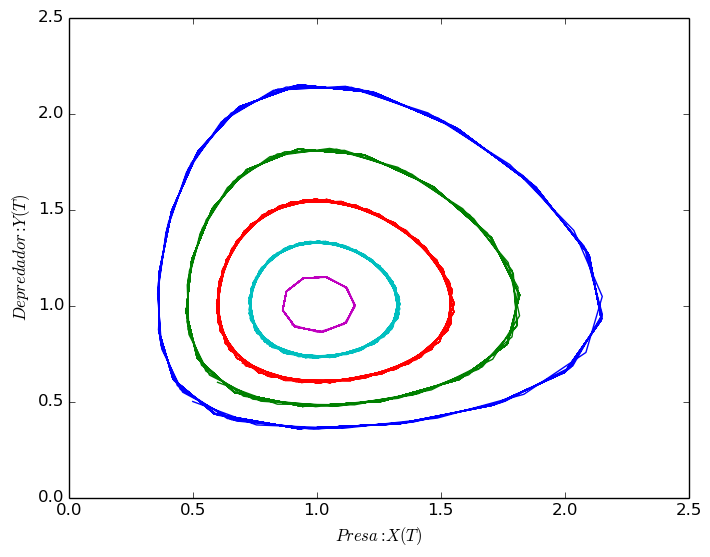

4-element Array{Float64,1}:
 0.0
 2.5
 0.0
 2.5

In [206]:
for j in 1:length(a1)   #Graficamos para 5 condiciones iniciales distintas.
    plot(a1[j],a2[j])   
end


xlabel(L"Presa:X(T)")
ylabel(L"Depredador:Y(T)")
axis([0,2.5,0,2.5])

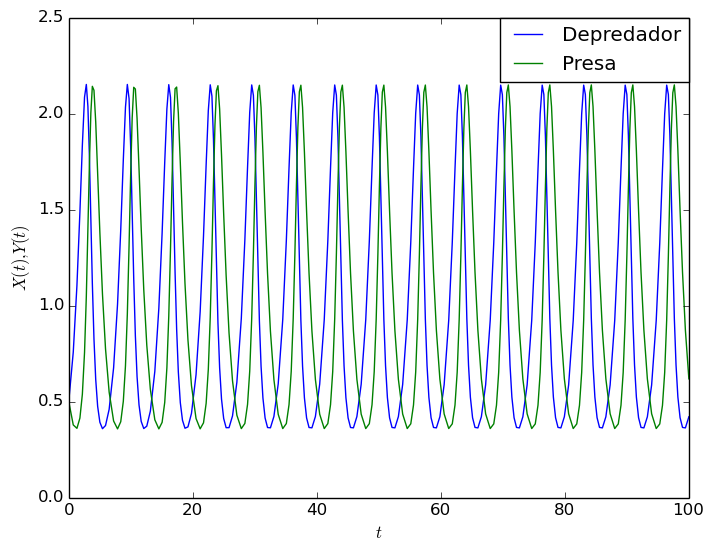

PyObject <matplotlib.text.Text object at 0xaa63f58c>

In [9]:
#Graficamos X y Y contra T, vemos que las gráficas son casi iguales pero desfasadas, esto es para la condición inicial (0.5,0.5)
line1,line2=plot(a3[1],a1[1],label="Depredador"),plot(a3[1],a2[1],label="Presa")
legend(loc=1, borderaxespad=0.0)
legend(loc=1, borderaxespad=0.0)
axis([0,100.0, 0,2.5])
xlabel(L"t")
ylabel(L"X(t),Y(t)")

Vemos que estos resultados tienen sentido matemáticamente ya que si obtenemos los puntos críticos del sistema, donde $\dot x,\dot y =0$ se observa que estos son el origen y el punto $(c/d,a/b)$.

Obtenemos la matriz Jacobiana del sistema:

$$J=\begin{bmatrix}
    a-by & -bx  \\
    dy & -c+dx \\
\end{bmatrix}$$

Y por lo tanto, observamos que en el origen hay un punto silla, y en el punto $(c/d,a/b)$ el sistema linealizado tiene la matriz de coeficientes:

$$\begin{bmatrix}
    0 & -(bc)/d  \\
    (ad)/b & 0 \\
\end{bmatrix}$$

Cuyos eigenvalores son $+-\sqrt{ac}i$, que al menos en el sistema linealizado es un centro estable (aunque el espacio fase graficado nos dice que probablemente también es un centro estable de nuestro sistema, ya que $(c/d,a/b)=(1,1)$ en el caso $a,b,c,d=1$ y si observamos lo graficado, todas las orbitas giran alrededor de ese punto en dirección contraria a las manecillas del reloj).

#### Crecimiento logístico de la presa:

Un problema obvio de este modelo básico es que la población de la presa crecería sin límites, exponencialmente, en la ausencia de depredadores. 
Hay una solución sencilla a este comportamiento no realista.
Tan solo reemplazaremos el término de crecimiento exponencial en la primera ecuación por dos términos que darán el crecimiento logístico de la población de la presa:

$$\dot x=(ax-ex^2)-bxy$$
$$\dot y=-cy+dxy$$

Definimos la función LV_2 que funciona con este nuevo sistema de ecuaciones:


In [117]:
function LV_2{T<:Real}(v::Array{T,1})
    
    xt=Taylor1(v[1],_ordenTaylor)
    yt=Taylor1(v[2],_ordenTaylor)
    
    for n=0:_ordenTaylor-1
        next=n+1    # Expansión de Taylor de orden k
        xTt=Taylor1(xt.coeffs[1:n+1],n)
        yTt=Taylor1(yt.coeffs[1:n+1],n)
        
        xp=(a*xTt-e*xTt^2)-b*xTt*yTt  #Aquí van las ecuaciones de Lotka_Volterra,
        yp=-c*yTt+d*yTt*xTt 
        
        xt.coeffs[next+1]=xp.coeffs[next]/next #Usando las ecuaciones anteriores definimos estas recurrencias.
        yt.coeffs[next+1]=yp.coeffs[next]/next
        
    end
    
    return Taylor1[xt,yt]
end


LV_2 (generic function with 1 method)

Por lo tanto, en la ausencia de depredadores, la primera ecuación indica que la población de la presa se estabilizaría según la capacidad de carga del ecosistema dada por la ecuación logística (primera ecuación).

En este sistema se tendrán 3 puntos criticos: el origen, otro en interior de nuestro conjunto S y otro en el eje x positivo.
Este último punto crítico esta en la capacidad de carga de la presa x(t), cuando y(t)=0.

Este punto se encontrará entonces en (e,0), donde e es la capacidad de carga del ecosistema para la presa.

Procedemos a graficar de nuevo,con las constantes a,b,c,d,e=4,-1,-2,2,-2

En esta ocasión también graficaremos el campo pendiente para observar el comportamiento de las soluciones de forma más clara.

In [221]:
f1(Y)=[(a*Y[1]-e*Y[1]^2)-b*Y[1]*Y[2],-c*Y[2]+d*Y[2]*Y[1]]  #Definos función para evaluar en varias condiciones iniciales.

f1 (generic function with 1 method)

In [222]:
a,b,c,d,e=4.0,1.0,2.0,2.0,2.0   #Constantes para LV
X=linspace(0,16,30)
Y=linspace(0,16,30)
grid_a = [(x,y) for x in X, y in Y] #Malla de 30x30 

u, v = zeros(30,30), zeros(30,30) #Creamos matrices de 20x20 de ceros

for i in 1:30       #Se hace un loop que evalua a f en varios puntos
    for j in 1:30   #del rectángulo cerrado [0,16]x[0,16] para así poder
        x = grid_a[i, j][1]  #graficar las pendientes
        y = grid_a[i, j][2]
        yprime = f1([x, y])
        u[i,j] = yprime[1]
        v[i,j] = yprime[2]
         end
    end

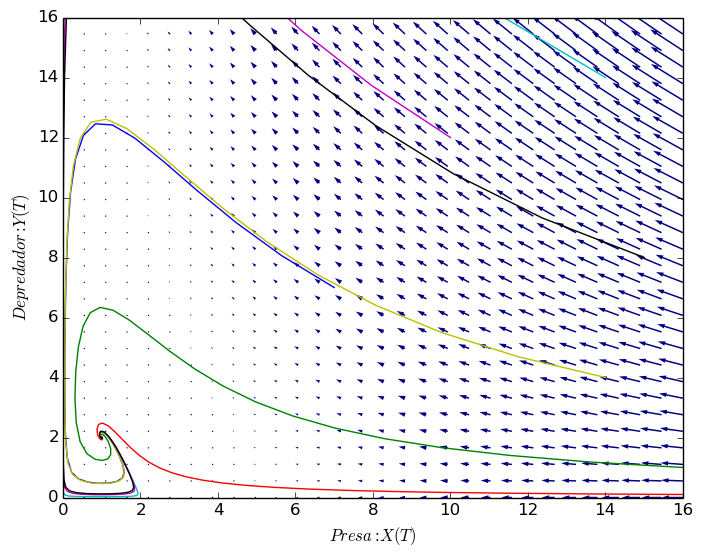

PyObject <matplotlib.text.Text object at 0xa3a9ef6c>

In [202]:
v1,v2=zeros(30,30), zeros(30,30) #Creamos de nuevo matrices de 20X20 de solo ceros.
for i in 1:30
    for j in 1:30
        v1[i,j]=grid_a[i,j][1]  #Se hace esto ya que el comando
        v2[i,j]=grid_a[i,j][2]  #para poder usar "quiver" de pyplot
    end
        
end

#Viendo las pendientes graficadas con quiver, se escogieron condiciones iniciales
#que pueden mostrarnos el compotamiento de las soluciones.
plot(Integracion(7.0,7.0,100.0,LV_2)[2],Integracion(7.0,7.0,100.0,LV_2)[3])
plot(Integracion(16.0,1.0,100.0,LV_2)[2],Integracion(16.0,1.0,100.0,LV_2)[3])
plot(Integracion(16.0,0.1,100.0,LV_2)[2],Integracion(16.0,0.1,100.0,LV_2)[3])
plot(Integracion(14.0,14.0,100.0,LV_2)[2],Integracion(14.0,14.0,100.0,LV_2)[3])
plot(Integracion(10.0,12.0,100.0,LV_2)[2],Integracion(10.0,12.0,100.0,LV_2)[3])
plot(Integracion(14.0,4.0,100.0,LV_2)[2],Integracion(14.0,4.0,100.0,LV_2)[3])
plot(Integracion(15.0,8.0,100.0,LV_2)[2],Integracion(15.0,8.0,100.0,LV_2)[3])
quiver(v1,v2,u,v,'r',headaxislength=5)
axis([0,16, 0,16])
xlabel(L"Presa:X(T)")
ylabel(L"Depredador:Y(T)")

Realizamos el paso anterior pero evaluando en todas las condiciones iniciales de nuestra malla:

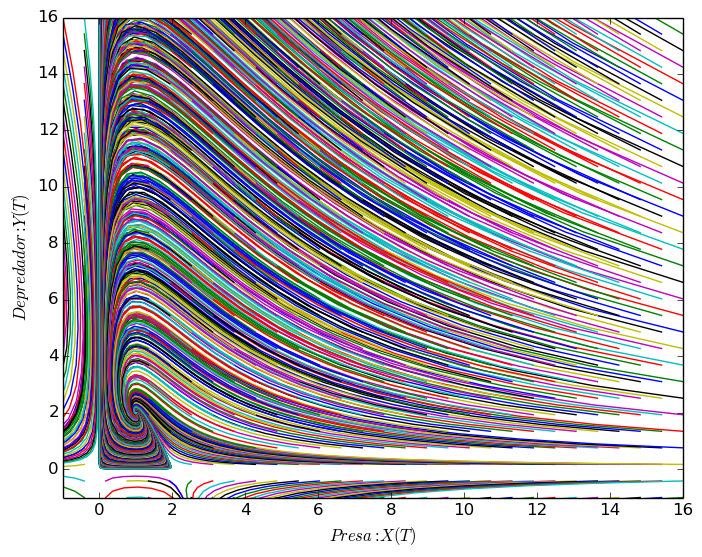

4-element Array{Float64,1}:
 -1.0
 16.0
 -1.0
 16.0

In [187]:
a11,a22,a33=Array[],Array[],Array[]  #Se crean arreglos vaciós para graficar con Pyplot.
for i in grid_a
    t1,x1,y1=Integracion(i[1],i[2],100.0,LV_2) 
    push!(a11,x1) #Se "depositan" los resultados en los arreglos a11,a2 y a3.
    push!(a22,y1)
    push!(a33,t1)
    end
for i in 1:length(a11)
    plot(a11[i],a22[i])  
end
xlabel(L"Presa:X(T)")
ylabel(L"Depredador:Y(T)")
axis([-1,16.0, -1,16.0])

En este plano fase se observa que hay un punto espiral asintóticamente estable en (1,2), y dos puntos silla en el (0,0) y (2,0), tal y como habíamos predicho.

Ahora graficamos a la presa y al depredador en función del tiempo:

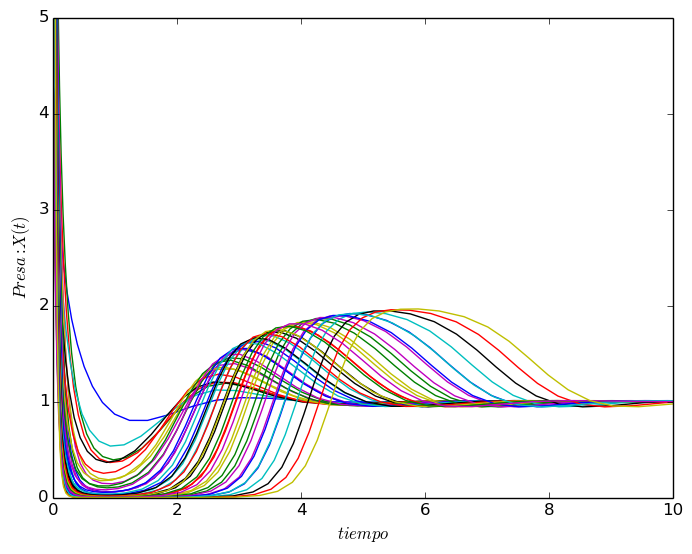

PyObject <matplotlib.text.Text object at 0xa3a470ec>

In [207]:
for w in 100:20:900  #Graficamos a la evolucion de la presa respecto al tiempo
    plot(a33[w],a11[w]) 
end
axis([0,10.0, 0,5.0])

ylabel(L"Presa:X(t)")
xlabel(L"tiempo")
    

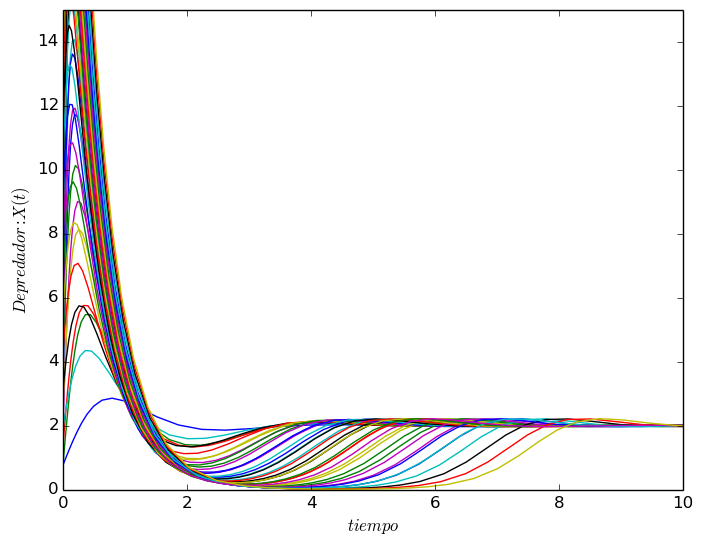

PyObject <matplotlib.text.Text object at 0xa14d01ec>

In [209]:
for w in 100:20:900 #Graficamos a la evolución del depredador con el tiempo
    plot(a33[w],a22[w])
end
axis([0,10, 0,15])

ylabel(L"Depredador:X(t)")
xlabel(L"tiempo")


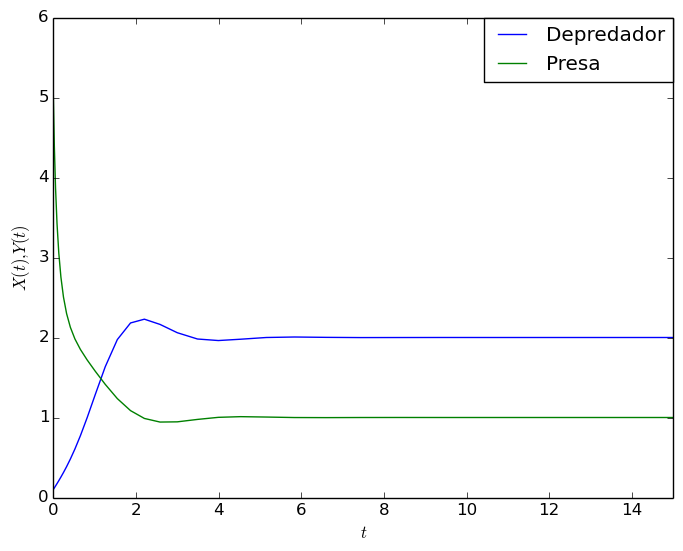

PyObject <matplotlib.text.Text object at 0xa4ad152c>

In [178]:
line1,line2=plot(a33[10],a22[10],label="Depredador"),plot(a33[10],a11[10],label="Presa")
legend(loc=1, borderaxespad=0.0)
legend(loc=1, borderaxespad=0.0)
axis([0,15.0, 0,6])
xlabel(L"t")
ylabel(L"X(t),Y(t)")


Gráfica anterior: Presa y depredador en el paso del tiempo para la condición inicial (0.1,5)

## Caso en 3-D:

El ecosistema que queremos modelar ahora es una cadena alimenticia de tres especies donde la presa de más bajo nivel, x, es cazada por un depredador de nivel medio y, pero al mismo tiempo y es cazado por un depredador de alto nivel z.

Ejemplos de tales ecosistemas serían: ratón-serpiente-búho, lombriz-canario-halcón,etc.
El modelo propuesto es el siguiente:

$$\dot x=ax-bxy$$
$$\dot y=-cy+dxy-eyz$$
$$\dot z=-fz+gyz$$

Donde $a,b,c,d,e,f,g>0$ y donde solo nos interesan las soluciones en el conjunto $P=\{(x,y,z)\in R^3 \| x\ge 0, y\ge 0, z\ge 0\}$

Definimos pues la función LV_3 con estas ecuaciones:



In [7]:
function LV_3D{T<:Real}( v::Array{T,1} )

    xt = Taylor1(v[1], _ordenTaylor)
    yt = Taylor1(v[2], _ordenTaylor)
    zt = Taylor1(v[3], _ordenTaylor)
    
    


    for n = 0:_ordenTaylor-1
        next = n+1
        # Expansión de Taylor de orden k
        xt1 = Taylor1( xt.coeffs[1:n+1], n)
        yt1 = Taylor1( yt.coeffs[1:n+1], n)
        zt1 = Taylor1( zt.coeffs[1:n+1], n)
        
        # Ecuaciones de Lotka-Volterra:
        
        
        xp = xt1-xt1*yt1
        yp = -yt1+yt1*xt1-yt1*zt1
        zp = -zt1+yt1*zt1
        # Recurrencias usando las ecuaciones anteriores:
        xt.coeffs[next+1]  = xp.coeffs[next] / next
        yt.coeffs[next+1]  = yp.coeffs[next] / next
        zt.coeffs[next+1]  = zp.coeffs[next] / next
        
    end
    
    return Taylor1[ xt, yt,zt ]
end

LV_3D (generic function with 1 method)

Ahora definimos la función Integracion2 ya que necesitamos modificar varias cosas para que sirva en 3-D:

In [8]:
function Integracion2(a::Float64,b::Float64,c::Float64,t::Float64,eqs::Function)
    t_0=0.0   # Condiciones iniciales
    x_0,y_0,z_0=a,b,c
    
    
    # Vectores para poder graficar las trayectorias con Pyplot
    t_v,x_v,y_v,z_v=Float64[],Float64[],Float64[],Float64[]
    push!(t_v,t_0)
    push!(x_v,x_0)
    push!(y_v,y_0)
    push!(z_v,z_0)
    
    #Incluimos un paso de integración mínimo por seguridad
    dt = 1.0
    while t_0<t && dt>1.0e-8
        dt,(x_1,y_1,z_1)=Taylorpasoint(eqs,[x_0,y_0,z_0]); 
        t_0=t_0+dt          #Por fin aquí integramos!
        push!(t_v,t_0)
        push!(x_v,x_1)
        push!(y_v,y_1)
        push!(z_v,z_1)
        
        x_0, y_0, z_0=x_1,y_1,z_1
    end

    return t_v,x_v,y_v,z_v
end

Integracion2 (generic function with 1 method)

Análogamente al caso en 2-D, primero graficamos para 5 condiciones iniciales distintas:

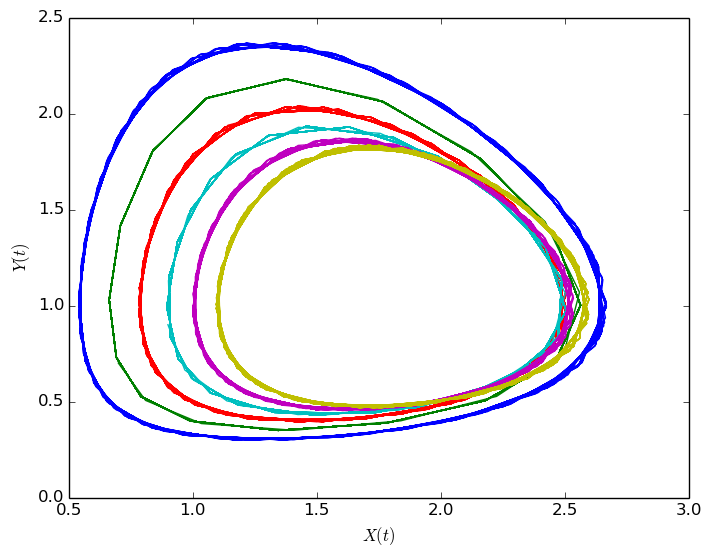

PyObject <matplotlib.text.Text object at 0xaa6d796c>

In [27]:
v3d0,v3d1,v3d2,v3d3=Array[],Array[],Array[],Array[]
for b in 1:20
    t03,x13,y13,z13=Integracion2(0.5+b*.1,0.5+b*.1,0.5+b*.1,100.0,LV_3D)
    push!(v3d0,t03)
    push!(v3d1,x13)
    push!(v3d2,y13)
    push!(v3d3,z13)
end
for i in 1:6
    plot(v3d1[i],v3d2[i])
end
xlabel(L"X(t)")   #Graficamos a la presa contra el primer depredador
ylabel(L"Y(t)")

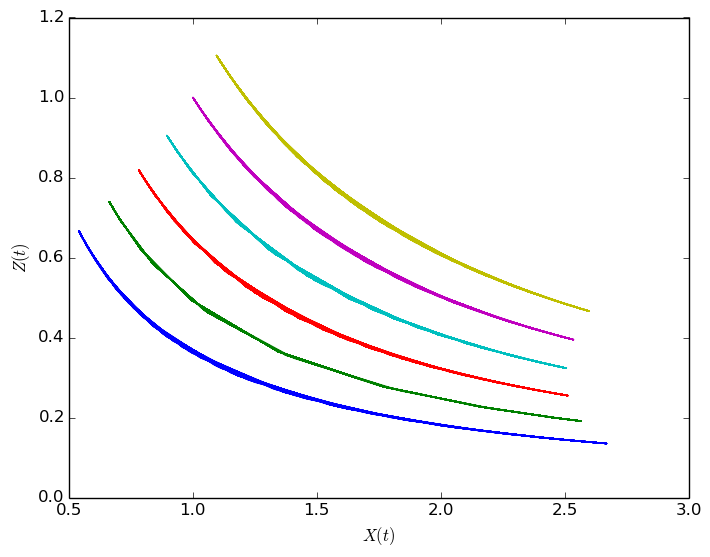

PyObject <matplotlib.text.Text object at 0xaa56048c>

In [22]:
for i in 1:6
    plot(v3d1[i],v3d3[i])
end
xlabel(L"X(t)")   #Graficamos a la presa contra el segundo depredador
ylabel(L"Z(t)")

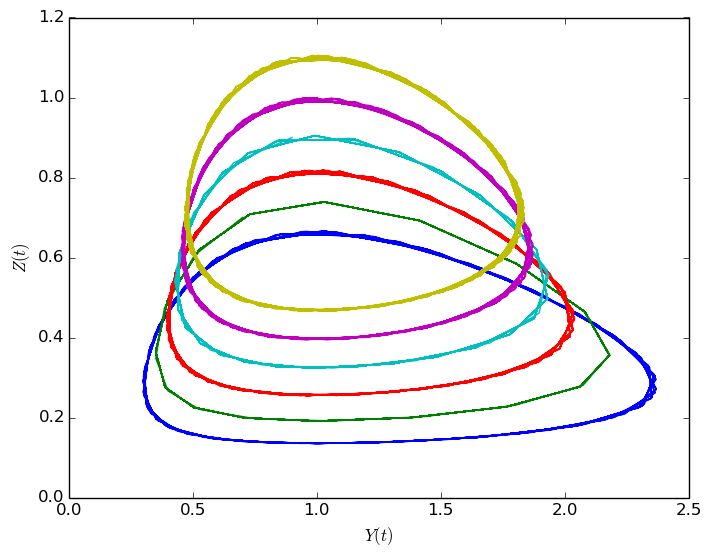

PyObject <matplotlib.text.Text object at 0xaa5174ec>

In [24]:
for i in 1:6
    plot(v3d2[i],v3d3[i])
end
xlabel(L"Y(t)")   #Graficamos al depredador 1 contra el 2, que en este caso se come al 1
ylabel(L"Z(t)")

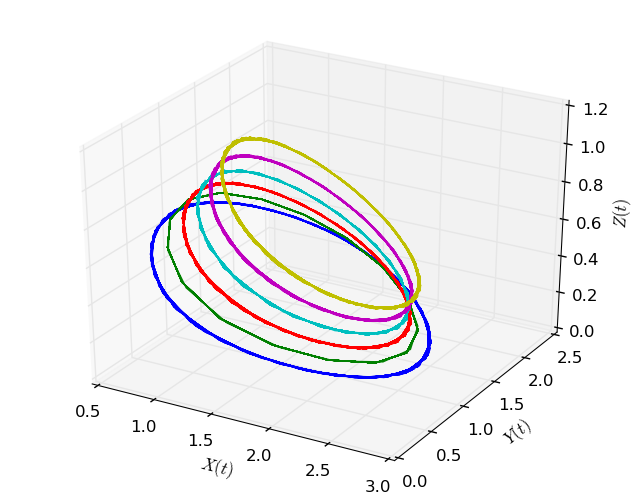

PyObject <matplotlib.text.Text object at 0xaa0a336c>

In [53]:
for i in 1:6    #Ahora graficamos en 3D
    plot3D(v3d1[i],v3d2[i],v3d3[i])
end
xlabel(L"X(t)")
ylabel(L"Y(t)")
zlabel(L"Z(t)")

Se observa pues comportamiento periódico y orbitas cerradas, que nos recuerdan un poco al caso 2-D con las mismas constantes $a,b,c,d,e=1,1,1,1,1$, pero en esta ocasión también tenemos nuevas constantes $f,g=1,1$

Para observar un comportamiento un poco más general, graficamos en varios puntos de la línea $(0.5t,0.5t,0.5t)$:
    

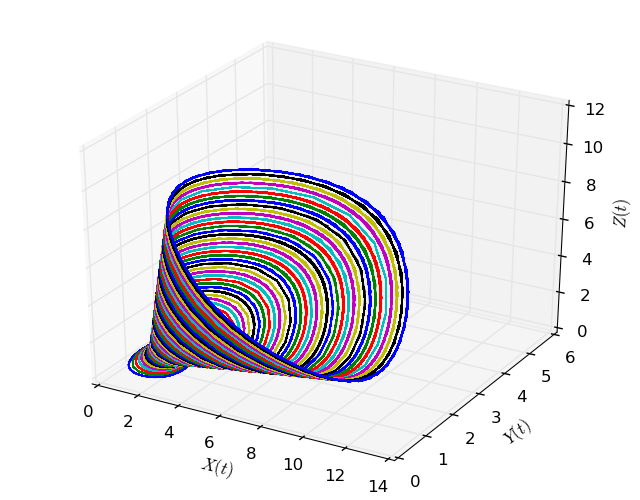

PyObject <matplotlib.text.Text object at 0xa9c5e2ac>

In [42]:
v1z,v2z,v3z,v4z=Array[],Array[],Array[],Array[] #Graficamos para 50 condiciones iniciales
for i in 1:50
    t3,x3,y3,z3=Integracion2(0.5+i*0.1,0.5+i*0.1,0.5+i*0.1,100.0,LV_3D)
    push!(v1z,t3)
    push!(v2z,x3)
    push!(v3z,y3)
    push!(v4z,z3)
end
for j in 1:50
    plot3D(v2z[j],v3z[j],v4z[j])
end
xlabel(L"X(t)")
ylabel(L"Y(t)")
zlabel(L"Z(t)")
    


Ahora graficamos X(t),Y(t) y Z(t) contra t para la condición inicial $(0.5,0.5,0.5)$:
    

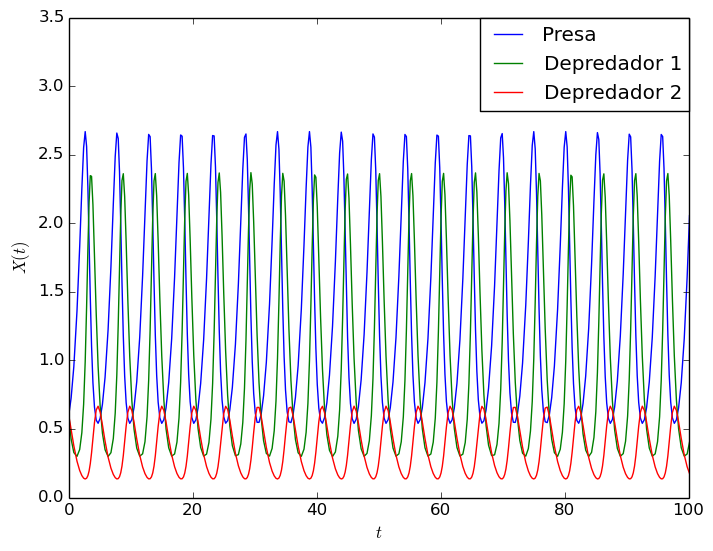

4-element Array{Float64,1}:
   0.0
 100.0
   0.0
   3.5

In [70]:
line11,line21,line31=plot(v1z[1],v2z[1],label="Presa"),plot(v1z[1],v3z[1],label="Depredador 1"),plot(v1z[1],v4z[1],label="Depredador 2")
legend(loc=1, borderaxespad=0.0)
xlabel(L"t")
ylabel(L"X(t)")
axis([0,100,0,3.5])

Vemos que al igual que el caso en 2-D, las poblaciones están desfasadas.


Ahora se considera un caso donde $ga\ne fb$
Ahora vamos a considerar el comportamiento de las trayectorias cuando $a,b,c,d,e,f=1,1,1,1,1$ y $g=0.88$ , nótese que en este caso $ga<fb$.

Definimos la función LV_3DD para usar estos coeficientes:


In [71]:
function LV_3DD{T<:Real}( v::Array{T,1} )

    xt = Taylor1(v[1], _ordenTaylor)
    yt = Taylor1(v[2], _ordenTaylor)
    zt = Taylor1(v[3], _ordenTaylor)
    
    


    for n = 0:_ordenTaylor-1
        next = n+1
        # Expansión de Taylor de orden k
        xt1 = Taylor1( xt.coeffs[1:n+1], n)
        yt1 = Taylor1( yt.coeffs[1:n+1], n)
        zt1 = Taylor1( zt.coeffs[1:n+1], n)
        
        # Ecuaciones de Lotka-Volterra:
        
        
        xp = xt1-xt1*yt1
        yp = -yt1+yt1*xt1-yt1*zt1
        zp = -zt1+0.88*yt1*zt1
        # Recurrencias usando las ecuaciones anteriores:
        xt.coeffs[next+1]  = xp.coeffs[next] / next
        yt.coeffs[next+1]  = yp.coeffs[next] / next
        zt.coeffs[next+1]  = zp.coeffs[next] / next
        
    end
    
    return Taylor1[ xt, yt,zt ]
end

LV_3DD (generic function with 1 method)

Graficamos la trayectoria para las condiciones iniciales $(1/2,1,2)$

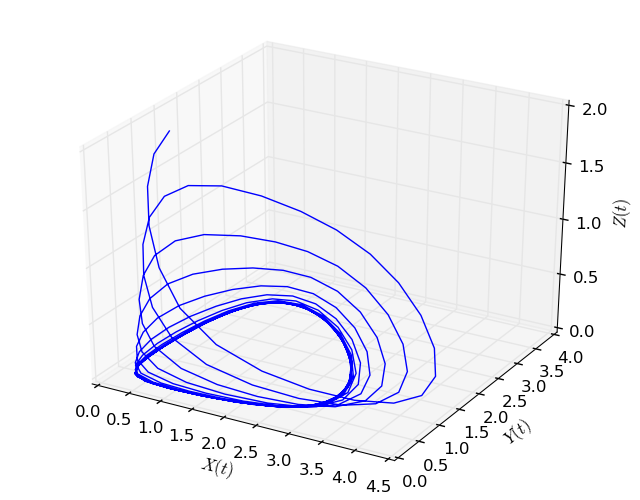

PyObject <matplotlib.text.Text object at 0xa8c13eec>

In [78]:
t33,x33,y33,z33=Integracion2(0.5,1.0,2.0,100.0,LV_3DD)
plot3D(x33,y33,z33)
xlabel(L"X(t)")
ylabel(L"Y(t)")
zlabel(L"Z(t)")

En este caso vemos que la solución cae en espiral al plano XY, lo que implica que el depredador $Z(t)$ termina extinguiéndose, esto es más claro en la gráfica de X,Y,Z respecto al tiempo, que procedemos a graficar:

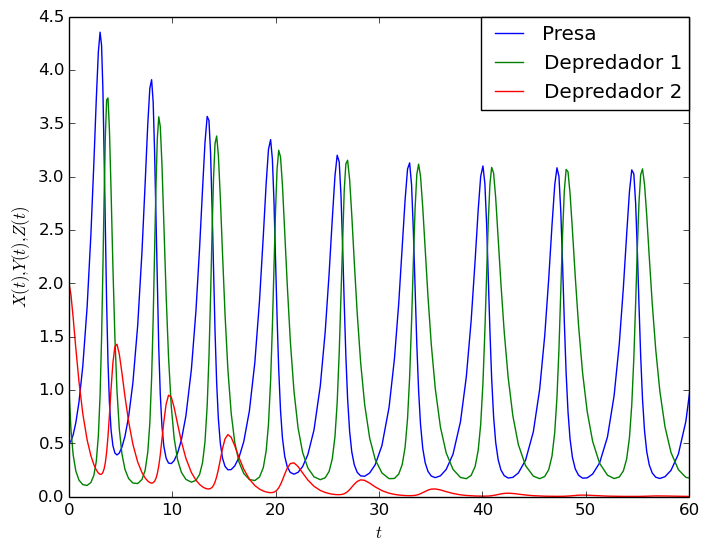

4-element Array{Float64,1}:
  0.0
 60.0
  0.0
  4.5

In [80]:
line11,line21,line31=plot(t33,x33,label="Presa"),plot(t33,y33,label="Depredador 1"),plot(t33,z33,label="Depredador 2")
legend(loc=1, borderaxespad=0.0)
xlabel(L"t")
ylabel(L"X(t),Y(t),Z(t)")
axis([0,60,0,4.5])

Graficamos ahora para varias condiciones iniciales:

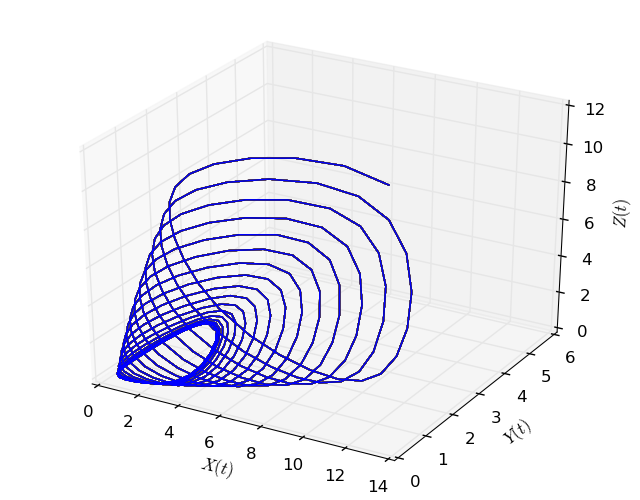

PyObject <matplotlib.text.Text object at 0xa8bde8ac>

In [87]:
pt,px,py,pz=Array[],Array[],Array[],Array[]
for i in 1:50
    t,x,y,z=Integracion2(1.0+i*0.1,1.0+i*0.1,1.0+i*0.1,100.0,LV_3DD)
    push!(pt,t)
    push!(px,x)
    push!(py,y)
    push!(pz,z)
end
for u in 1:50
    plot3D(px[i],py[i],pz[i])
end
xlabel(L"X(t)")
ylabel(L"Y(t)")
zlabel(L"Z(t)")
    

Esto resulta ser bastante interesante, ya que a pesar de tener alimento disponible, el depredador 2 termina extinguiéndose.

Ahora graficamos una trayectoria donde $ga>fb$, usando los parámetros $a,b,c,d,e,f=1$, y $g=1.6$ para esto definimos la función LV_3D1:

In [91]:
function LV_3D1{T<:Real}( v::Array{T,1} )

    xt = Taylor1(v[1], _ordenTaylor)
    yt = Taylor1(v[2], _ordenTaylor)
    zt = Taylor1(v[3], _ordenTaylor)
    
    


    for n = 0:_ordenTaylor-1
        next = n+1
        # Expansión de Taylor de orden k
        xt1 = Taylor1( xt.coeffs[1:n+1], n)
        yt1 = Taylor1( yt.coeffs[1:n+1], n)
        zt1 = Taylor1( zt.coeffs[1:n+1], n)
        
        # Ecuaciones de Lotka-Volterra:
        
        
        xp = xt1-xt1*yt1
        yp = -yt1+yt1*xt1-yt1*zt1
        zp = -zt1+1.66*yt1*zt1
        
        # Recurrencias usando las ecuaciones anteriores:
        
        xt.coeffs[next+1]  = xp.coeffs[next] / next
        yt.coeffs[next+1]  = yp.coeffs[next] / next
        zt.coeffs[next+1]  = zp.coeffs[next] / next
        
    end
    
    return Taylor1[ xt, yt,zt ]
end

LV_3D1 (generic function with 1 method)

Graficamos para la condición inicial $(.5,1,2)$:

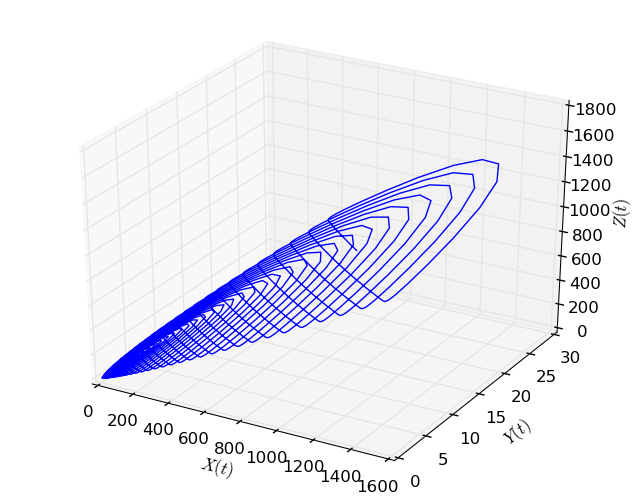

PyObject <matplotlib.text.Text object at 0xa821a4ac>

In [102]:
t331,x331,y331,z331=Integracion2(0.5,1.0,2.0,30.0,LV_3D1)
plot3D(x331,y331,z331)
xlabel(L"X(t)")
ylabel(L"Y(t)")
zlabel(L"Z(t)")

Graficamos en función del tiempo:

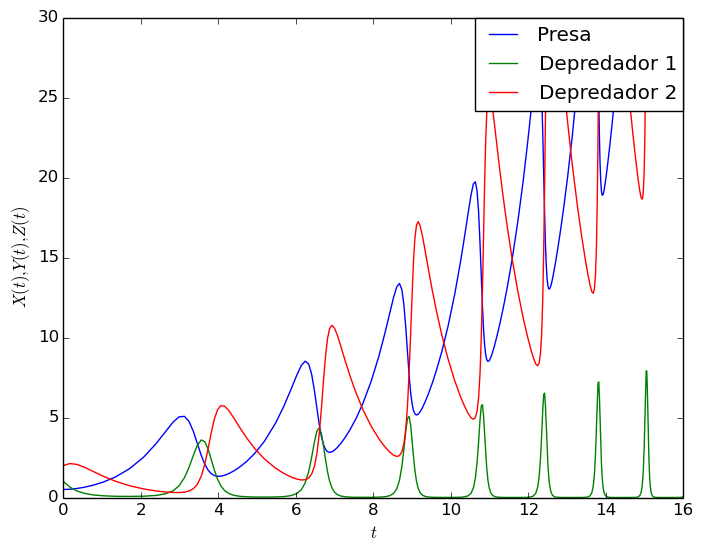

4-element Array{Int32,1}:
  0
 16
  0
 30

In [104]:
line11,line21,line31=plot(t331,x331,label="Presa"),plot(t331,y331,label="Depredador 1"),plot(t331,z331,label="Depredador 2")
legend(loc=1, borderaxespad=0.0)
xlabel(L"t")
ylabel(L"X(t),Y(t),Z(t)")
axis([0,16,0,30])